In [1]:
import numpy as np
import torch
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
nltk.download('stopwords', download_dir="data")

[nltk_data] Downloading package stopwords to data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# load and split dataset
df = pd.read_csv('IMDB Dataset.csv')

x_train_raw,x_test_raw,y_train_raw,y_test_raw = train_test_split(df['review'].values,df['sentiment'].values, test_size=0.25, random_state=1, shuffle=True, stratify=df['sentiment'].values)

display(df.head())
print(f'number of train samples is {x_train_raw.shape}')
print(f'number of test samples is {x_test_raw.shape}')

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


number of train samples is (37500,)
number of test samples is (12500,)


In [5]:
def prepro_string(w_str):
    w_str = re.sub(r"[^\w\s]", '', w_str)
    w_str = re.sub(r"\s+", '', w_str)
    w_str = re.sub(r"\d", '', w_str)
    return w_str

def tocken_w(x_tra_raw,y_tra_raw,x_val_raw,y_val_raw, seq_len):
    word_list = []
    stop_words = set(stopwords.words('english'))
    
    for sent in x_tra_raw:
        for w in sent.lower().split():
            w = prepro_string(w)
            if w not in stop_words and w != '':
                word_list.append(w)

    corpus_ = sorted(Counter(word_list),key=Counter(word_list).get,reverse=True)[:500]
    vocab_dict = {w:i for i,w in enumerate(corpus_)}

    l_train,l_test = [],[]
    for sent in x_train_raw:
        l_train.append([vocab_dict[prepro_string(word)] for word in sent.lower().split()
                                 if prepro_string(word) in vocab_dict.keys()])
    for sent in x_val_raw:
        l_test.append([vocab_dict[prepro_string(word)] for word in sent.lower().split()
                                if prepro_string(word) in vocab_dict.keys()])

    # padding to same length with zeros
    x_train = np.zeros((len(l_train), seq_len),dtype=int)
    for i, review in enumerate(l_train):
        if len(review) != 0:
            x_train[i, -len(review):] = np.array(review)[:seq_len]

    x_test = np.zeros((len(l_test), seq_len),dtype=int)
    for i, review in enumerate(l_test):
        if len(review) != 0:
            x_test[i, -len(review):] = np.array(review)[:seq_len]

    y_train = np.array([1 if label =='positive' else 0 for label in y_train_raw])
    y_test = np.array([1 if label =='positive' else 0 for label in y_val_raw])
    return x_train, y_train,x_test, y_test, vocab_dict


In [6]:
x_train,y_train,x_test,y_test,vocab = tocken_w(x_train_raw,y_train_raw,x_test_raw,y_test_raw, seq_len = 500)

In [7]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import pandas as pd

In [8]:
# DataLoader
batch_size = 32

ds_train = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
ds_test = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))


dl_train = DataLoader(ds_train, batch_size=batch_size, drop_last=True, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, drop_last=True, shuffle=False)

In [17]:
# define the transformer encoder
import torch

class TransformerEncoderModule(torch.nn.Module):
    def __init__(self, d_model: int, n_head: int, num_layers: int) -> None:
        super().__init__()
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        

    def forward(self, x):
        return self.transformer(x)

In [20]:
import pytorch_lightning as pl
from typing import Any
from torchmetrics.functional.classification import binary_accuracy
from torchmetrics.classification import BinaryConfusionMatrix, BinaryAccuracy, BinaryAUROC
import torch

class EncoderWrapper(pl.LightningModule):

    def __init__(self, 
        loss: callable, 
        lr: float,
        model: torch.nn.Module,
    ) -> None:
        super().__init__()

        self.loss = loss
        self.lr = lr

        self.model = model
        
        # eval stuff
        self.val_auroc = BinaryAUROC()
        self.val_acc = BinaryAccuracy()
        self.val_conf_mat = BinaryConfusionMatrix(threshold=0.5)

        self.test_auroc = BinaryAUROC()
        self.test_acc = BinaryAccuracy()
        self.test_conf_mat = BinaryConfusionMatrix(threshold=0.5)       

    def forward(self, x: torch.Tensor, h, c) -> torch.Tensor:
        out = self.model(emb)
        return out

    def _step(self, batch, h, c) -> torch.Tensor:
        x, y = batch
        pred  = self.forward(x)
        loss = self.loss(pred, y.float())
        return pred, loss

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        pred, loss = self._step(batch)
        self.log("train/loss", loss)
        acc = binary_accuracy(pred, batch[-1])
        self.log("train/acc", acc)
        return loss
    
    def _eval_step(self, batch, auroc, conf, acc):
        pred, loss = self._step(batch)
        auroc.update(pred, batch[-1])
        acc.update(pred, batch[-1])
        conf.update(pred, batch[-1])

        return loss

    def _eval_epoch_end(self, eval_type, auroc, acc, conf_mat):
        auroc_val = auroc.compute()
        acc_val = acc.compute()
        conf_val = conf_mat.compute()
        print(f"{eval_type} AUROC: {auroc_val.data}")
        print(f"{eval_type} Accuracy: {acc_val.data}")
        print(f"{eval_type} Conf Mat: {conf_val.data}")
        self.log(f"{eval_type}/auroc", auroc_val)
        self.log(f"{eval_type}/acc", acc_val)
        self.conf_mat = conf_val.detach()
        #self.log(f"{eval_type}/conf", conf_val)

        
    def test_step(self, batch: torch.Tensor, batch_idx: int) -> torch.Tensor:
        loss = self._eval_step(batch, self.test_auroc, self.test_acc, self.test_conf_mat)

    def test_epoch_end(self, outputs) -> None:
        self._eval_epoch_end("Test", self.test_auroc, self.test_acc, self.test_conf_mat)

    def validation_step(self, batch: torch.Tensor, batch_idx: int) -> torch.Tensor:
        loss = self._eval_step(batch, self.val_auroc, self.val_acc)
        self.log("test", loss)

    def validation_epoch_end(self, outputs) -> None:
        self._eval_epoch_end("Val", self.val_auroc, self.val_acc, self.val_conf_mat)
                
    def configure_optimizers(self) -> Any:
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optim

In [23]:
log_intervall = 10
epochs = 10
lr=1e-3
criterion = nn.BCELoss()

vocab_size = len(vocab)
embedding_dim = 400
hidden_size = 128
num_layers = 5
seq_len = 500
n_head = 8
num_layers = 6

emb = nn.Embedding(vocab_size, embedding_dim)

transformer = TransformerEncoderModule(d_model=embedding_dim, n_head=n_head, num_layers=num_layers)

classification_head = nn.Sequential(
    nn.Flatten(),
    nn.Linear(hidden_size * seq_len, 1),
    nn.Sigmoid(),
)

x0, y0 = next(iter(dl_train))
arch = torch.nn.Sequential(emb, transformer, classification_head)

print(x0.shape)
arch(x0)

# lstm_model = EncoderWrapper(
#     loss=criterion, 
#     lr=lr,
#     model=arch,
# )

torch.Size([32, 500])


In [10]:
trainer = pl.Trainer(max_epochs=epochs, accelerator="gpu", devices=1, log_every_n_steps=log_intervall)
trainer.fit(lstm_model, dl_train)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:109: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

In [11]:
trainer.test(lstm_model, dl_test)

Testing: 0it [00:00, ?it/s]

Test AUROC: 0.9037129282951355
Test Accuracy: 0.8208821415901184
Test Conf Mat: tensor([[5167,  971],
        [1230, 4920]], device='cuda:0')
tensor([[5167,  971],
        [1230, 4920]], device='cuda:0')


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Test/acc          │    0.8208821415901184     │
│        Test/auroc         │    0.9037129282951355     │
└───────────────────────────┴───────────────────────────┘

[{'Test/auroc': 0.9037129282951355, 'Test/acc': 0.8208821415901184}]

In [12]:
conf_mat = lstm_model.conf_mat.cpu().numpy()

<AxesSubplot:>

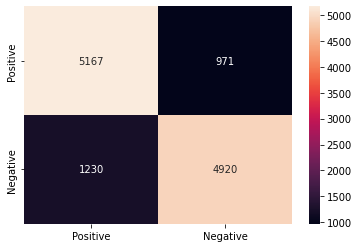

In [13]:
import seaborn as sns

sns.heatmap(conf_mat,annot=True, fmt='g', xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])

In [ ]:
# Inspect the Logs if you are interested
%load_ext tensorboard
%tensorboard --logdir lightning_logs

# No Math this Week :( sadly i do not have time for it 